In [1]:
import cv2
import matplotlib.pyplot as plt

camera_index = 0


In [2]:
cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW) # this is the magic!


In [3]:
import pygame 
import os
pygame.init()
# Load the image

# Get available display info
display_info = pygame.display.get_desktop_sizes()
if len(display_info) < 2:
    print("Only one display detected. Cannot switch to a secondary screen.")
    sys.exit()

# Choose the secondary screen
secondary_screen_index = 0  # Index 1 corresponds to the second screen
secondary_screen_width, secondary_screen_height = display_info[secondary_screen_index]
# Set the environment variable to position the window on the secondary screen
os.environ['SDL_VIDEO_WINDOW_POS'] = f"{display_info[0][0]},{0}"  # Position at the start of the second screen

x = 0
y = 0
os.environ['SDL_VIDEO_WINDOW_POS'] = f"{x},{y}"

# Create a window with the secondary screen resolution


pygame 2.6.1 (SDL 2.28.4, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:

import numpy as np

scale = 1

pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 


In [5]:
pattern.shape

(1920, 1080, 3)

In [6]:
# import matplotlib.pyplot as plt
# plt.imshow(pattern)

In [7]:
# import cv2
# pattern = cv2.imread(r"D:\Users\danny\Downloads\my_pattern3.png")

In [8]:
import time
import tqdm 

screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

caps_x = []
caps_y = []

jumps = 10

for i in tqdm.tqdm(range(0,pattern.shape[0],jumps)):
    pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 
    pattern[i,:,:] = 255


    screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

    image_surface = pygame.surfarray.make_surface(pattern)
    screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
    pygame.display.update()  # Update the display
    time.sleep(0.1)
    for k in range(5):
        ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
    else:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        caps_x.append(frame)



for i in tqdm.tqdm(range(0,pattern.shape[1],jumps)):
    pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 
    pattern[:,i,:] = 255


    screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

    image_surface = pygame.surfarray.make_surface(pattern)
    screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
    pygame.display.update()  # Update the display
    time.sleep(0.1)
    for k in range(5):
        ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
    else:
        # convert frame to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        caps_y.append(frame)

 83%|████████▎ | 160/192 [00:41<00:08,  3.82it/s]


KeyboardInterrupt: 

In [9]:
# calculate the diffrance between every sequantial frame
caps_x = np.array(caps_x)
caps_x_diff = np.diff(caps_x.reshape(caps_x.shape[0],-1),axis=0)
assert (caps_x_diff.sum(-1) == 0).any() == False

caps_y = np.array(caps_y)
caps_y_diff = np.diff(caps_y.reshape(caps_y.shape[0],-1),axis=0)
assert (caps_y_diff.sum(-1) == 0).any() == False

In [43]:
positions = []
counter = 0
from tqdm import tqdm_notebook as tqdm

pbar = tqdm(total=len(caps_x)*len(caps_y))

for x in range(len(caps_x)):
    for y in range(len(caps_y)):   
        #find vertical line in caps_x and horizontal line in caps_y
        edges_x = cv2.Canny(caps_x[x], 50, 150, apertureSize=3)
        edges_y = cv2.Canny(caps_y[y], 50, 150, apertureSize=3)
        if edges_x.max() != 255 or edges_y.max() != 255:
            # print('bad frame')
            continue
        
        idx_x, idx_y = np.array(((edges_x == 255) * (edges_y == 255)).nonzero()).T.mean(0).astype(int)
        comb = edges_x + edges_y
        positions.append(((x * jumps,y * jumps),(idx_x,idx_y)))
        counter +=1 
        pbar.update(1)
        # if counter % 1000 == 0:
        #     plt.imshow(comb)
        #     plt.scatter(idx_y,idx_x)
        #     plt.show()


C:\Users\danny\AppData\Local\Temp\ipykernel_14668\4028687413.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(total=len(caps_x)*len(caps_y))


  0%|          | 0/20736 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [42]:
cv2.Canny(caps_x, 50, 150, apertureSize=3).shape

(192, 480)

In [11]:
original_points = np.array([x[0] for x in positions])
new_points = np.array([x[1] for x in positions])

H, _ = cv2.findHomography(original_points, new_points, cv2.RANSAC)


In [12]:
# pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 
# print(pattern.shape)
# # add eye to the pattern
# pattern[0,:,:] += 255
# pattern[-1,:,:] += 255
# pattern[:,0,:] += 255
# pattern[:,-1,:] += 255

pattern = cv2.imread(r"D:\Users\danny\Downloads\my_pattern3.png")

pattern = cv2.resize(pattern, (secondary_screen_width//scale, secondary_screen_height//scale))

im_dst = cv2.warpPerspective(  pattern.transpose(1,0,2), H, (caps_x.shape[1], caps_x.shape[2]))

In [13]:
print(im_dst.shape)
print(caps_x[0].shape)

(640, 480, 3)
(480, 640)


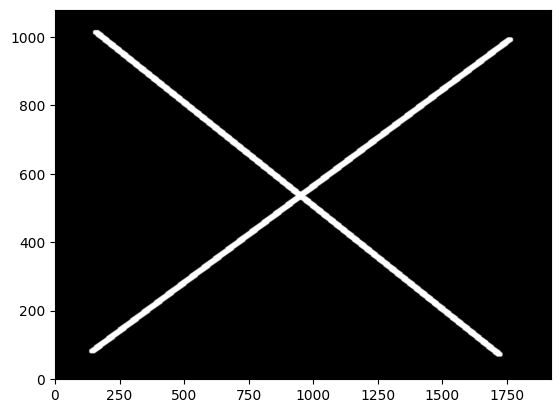

In [ ]:
plt.imshow(pattern, cmap='gray',origin='lower', aspect='auto')

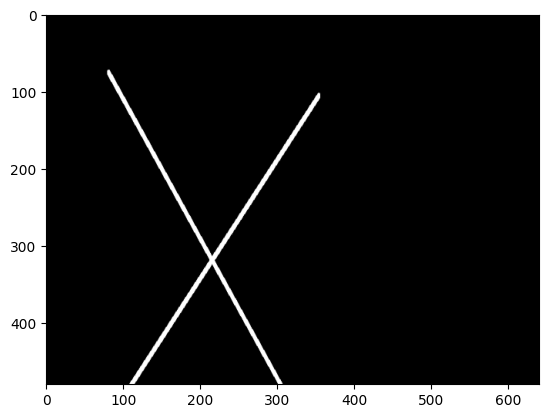

In [15]:
plt.imshow(im_dst.transpose(1,0,2), cmap='gray')

In [16]:
np.unravel_index(np.argmax(im_dst, axis=None), im_dst.shape)

(80, 73, 0)

In [17]:


screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

image_surface = pygame.surfarray.make_surface(pattern)
screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
pygame.display.update()  # Update the display

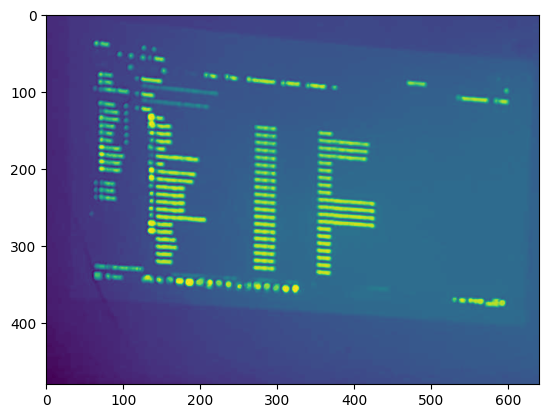

In [18]:
for i in range(5):
    ret, frame = cap.read()
if not ret:
    print("Failed to grab frame")
else:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

plt.imshow(frame)

In [19]:
# find the max value in the image 
np.unravel_index(np.argmax(frame, axis=None), frame.shape)

(348, 184)

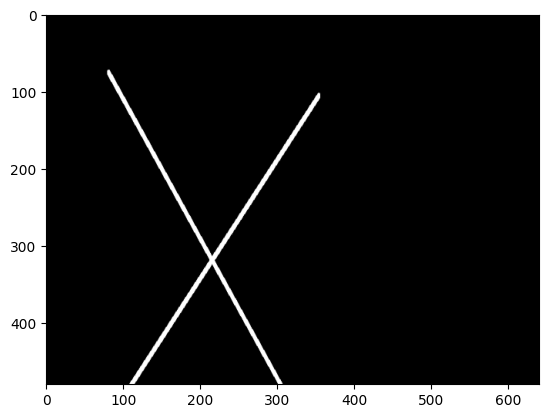

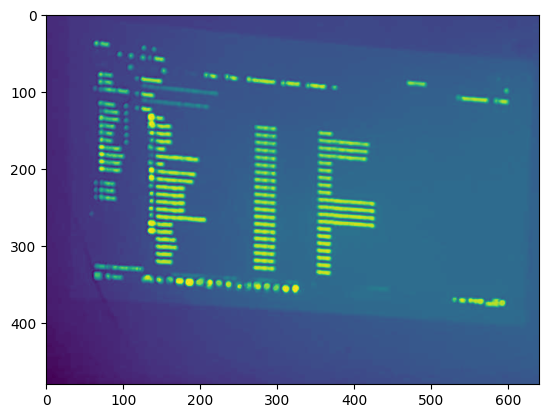

In [ ]:
plt.imshow(im_dst.transpose(1,0,2))
plt.show()
plt.imshow(frame.reshape(frame.shape[0],frame.shape[1],1))


In [21]:
dst_mask = (im_dst.transpose(1,0,2).sum(-1) != 0).astype(np.uint8)
# add third dimension
d = np.stack([dst_mask*0,dst_mask*255,dst_mask*0],axis=-1)

frame_mask = (frame > 220).astype(np.uint8)
f = np.stack([frame_mask*0,frame_mask*0,frame_mask*255],axis=-1)

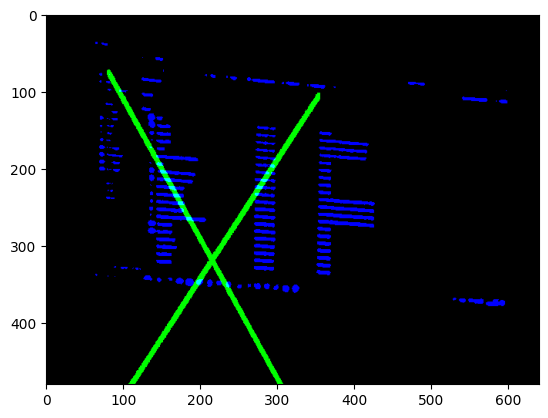

In [22]:
plt.imshow(f+d)

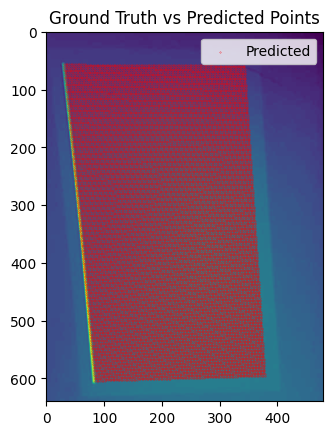

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Warp original points
warped_points_pred = cv2.perspectiveTransform(original_points.reshape(-1, 1, 2).astype(np.float32), H)

# Plot on the captured image
# plt.imshow(new_points, cmap='gray')
# plt.scatter(new_points[:, 0], new_points[:, 1], c='blue', label='Ground Truth')
plt.imshow(caps_y[0].T)
plt.scatter(warped_points_pred[:, 0, 0], warped_points_pred[:, 0, 1], c='red', label='Predicted', s=0.05)
plt.legend()
plt.title('Ground Truth vs Predicted Points')
plt.show()

In [25]:
# inverse new points
H_inv = np.linalg.pinv(H)

H_back, _ = cv2.findHomography(new_points, original_points, cv2.RANSAC)

# Warp original points
warped_points_pred = cv2.perspectiveTransform(new_points.reshape(-1, 1, 2).astype(np.float32), H_back)


In [26]:
np.linalg.det(H)

-0.09086741448712272

In [27]:
H @ H_back

array([[ 9.95115196e-01,  3.07139504e-04, -7.57526187e-01],
       [-1.41154814e-03,  9.98749668e-01, -1.41923680e+00],
       [-6.38679936e-07,  4.26765707e-06,  9.92239605e-01]])

In [28]:
H_back

array([[-2.98310359e-02,  3.28097711e+00, -1.86616507e+02],
       [ 3.33589888e+00, -3.29093000e-01, -8.44178701e+01],
       [-6.89088389e-05, -9.45395484e-05,  1.00000000e+00]])

In [29]:
H_inv

array([[-2.54342361e-02,  3.28587602e+00, -1.83395560e+02],
       [ 3.35175247e+00, -3.30181113e-01, -8.29914817e+01],
       [-6.87407346e-05, -9.89423531e-05,  1.00762709e+00]])

In [30]:
positions

[((0, 0), (30, 55)),
 ((0, 10), (32, 56)),
 ((0, 20), (35, 56)),
 ((0, 30), (38, 57)),
 ((0, 40), (41, 57)),
 ((0, 50), (44, 56)),
 ((0, 60), (47, 55)),
 ((0, 70), (50, 55)),
 ((0, 80), (53, 55)),
 ((0, 90), (56, 55)),
 ((0, 100), (59, 55)),
 ((0, 110), (62, 55)),
 ((0, 120), (64, 56)),
 ((0, 130), (68, 55)),
 ((0, 140), (71, 55)),
 ((0, 150), (74, 55)),
 ((0, 160), (76, 55)),
 ((0, 170), (79, 55)),
 ((0, 180), (83, 56)),
 ((0, 190), (86, 55)),
 ((0, 200), (89, 55)),
 ((0, 210), (92, 55)),
 ((0, 220), (95, 57)),
 ((0, 230), (98, 57)),
 ((0, 240), (101, 57)),
 ((0, 250), (104, 57)),
 ((0, 260), (107, 57)),
 ((0, 270), (110, 57)),
 ((0, 280), (113, 57)),
 ((0, 290), (116, 57)),
 ((0, 300), (119, 57)),
 ((0, 310), (122, 58)),
 ((0, 320), (125, 57)),
 ((0, 330), (127, 56)),
 ((0, 340), (127, 56)),
 ((0, 350), (130, 56)),
 ((0, 360), (133, 56)),
 ((0, 370), (139, 58)),
 ((0, 380), (142, 58)),
 ((0, 390), (145, 58)),
 ((0, 400), (148, 58)),
 ((0, 410), (151, 58)),
 ((0, 420), (154, 58)),
 ((

In [31]:
warped_points_pred

array([[[  -7.1093607,   -2.458887 ]],

       [[  -3.8653698,    3.9311671]],

       [[  -3.9563632,   14.017402 ]],

       ...,

       [[1918.5996   , 1049.6232   ]],

       [[1918.9343   , 1060.7655   ]],

       [[1915.6068   , 1075.8774   ]]], dtype=float32)

In [32]:

pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8)

screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

image_surface = pygame.surfarray.make_surface(pattern)
screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
pygame.display.update()  # Update the display

In [33]:

scale=1
screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 

image_surface = pygame.surfarray.make_surface(pattern)
screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
pygame.display.update()  # Update the display

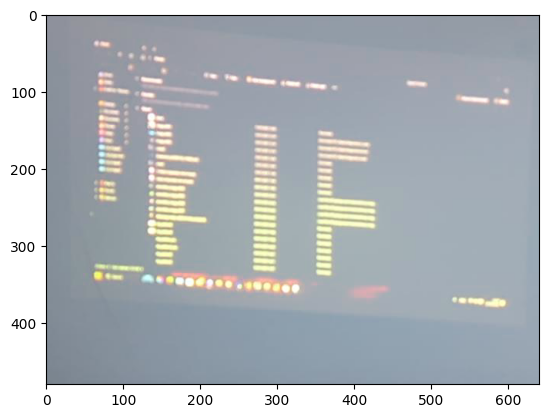

In [ ]:
ret, frame = cap.read()
plt.imshow(frame)

In [35]:
def find_rectangles(frame):
    blurred = cv2.GaussianBlur(frame, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    rectangles = []
    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if it's a rectangle
        if len(approx) == 4 and cv2.isContourConvex(approx):
            # Calculate the aspect ratio and area
            area = cv2.contourArea(approx)
            if area > 100:  # Filter small shapes
                # check if the rectangle is black
                x, y, w, h = cv2.boundingRect(approx)
                if frame[y:y+h, x:x+w].mean() < 150:
                    rectangles.append(approx)

    return rectangles    

def find_rect_centers(rectangles):
    rect_mid = []
    for rect in rectangles:
        rect_mid.append(rect.mean(0).astype(int)[0])
    return np.array(rect_mid)

def find_rect_lines(approx):
    a=approx[:,:,0].max()
    b=approx[:,:,0].min()
    c=approx[:,:,1].max()
    d=approx[:,:,1].min()
    ba = np.arange(b,a)
    cd = np.arange(d,c)
    line_1 = np.array(list(zip(ba,np.ones_like(ba)*d)))
    line_2 = np.array(list(zip(ba,np.ones_like(ba)*c)))
    line_3 = np.array(list(zip(np.ones_like(cd)*b,cd)))
    line_4 = np.array(list(zip(np.ones_like(cd)*a,cd)))
    return line_1,line_2,line_3,line_4
                  

In [36]:
for ww in range(1000):
    for i in range(2):
        ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
    else:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    screen = pygame.display.set_mode((secondary_screen_width, secondary_screen_height), pygame.FULLSCREEN, display=0)

    pattern = np.zeros((secondary_screen_width//scale, secondary_screen_height//scale,3),dtype=np.uint8) 

    rectangles = find_rectangles(frame)
    # print(rect_mids)
    for rect in rectangles:
        line_s = find_rect_lines(rect)
        for line in line_s:
            warped_points_pred = cv2.perspectiveTransform(line.reshape(-1, 1, 2).astype(np.float32), H_back).astype(int)
            if warped_points_pred.min() > 0 and warped_points_pred[:,0,1].max()\
                  < pattern.shape[0] and warped_points_pred[:,0,0].max() < pattern.shape[1]:
                    pattern[warped_points_pred[:,0,1],warped_points_pred[:,0,0]] = 255
            # warped_points_pred = find_nearest_or_interpolate(rect_mid).astype(int)
            # print(warped_points_pred)
            # pattern[warped_points_pred[1]:warped_points_pred[1]+10,warped_points_pred[0]:+warped_points_pred[0]+10,:] = 255

    image_surface = pygame.surfarray.make_surface(pattern)
    screen.blit(image_surface, (0, 0))  # Draw the surface onto the screen
    pygame.display.update()  # Update the display




KeyboardInterrupt: 

In [138]:
 cv2.perspectiveTransform(line.reshape(-1, 1, 2).astype(np.float32), H_back).astype(int)

(145, 1, 2)

In [140]:
warped_points_pred = cv2.perspectiveTransform(line.reshape(-1, 1, 2).astype(np.float32), H_back).astype(int)


In [142]:
line

array([[309,  50],
       [309,  51],
       [309,  52],
       [309,  53],
       [309,  54],
       [309,  55],
       [309,  56],
       [309,  57],
       [309,  58],
       [309,  59],
       [309,  60],
       [309,  61],
       [309,  62],
       [309,  63],
       [309,  64],
       [309,  65],
       [309,  66],
       [309,  67],
       [309,  68],
       [309,  69],
       [309,  70],
       [309,  71],
       [309,  72],
       [309,  73],
       [309,  74],
       [309,  75],
       [309,  76],
       [309,  77],
       [309,  78],
       [309,  79],
       [309,  80],
       [309,  81],
       [309,  82],
       [309,  83],
       [309,  84],
       [309,  85],
       [309,  86],
       [309,  87],
       [309,  88],
       [309,  89],
       [309,  90],
       [309,  91],
       [309,  92],
       [309,  93],
       [309,  94],
       [309,  95],
       [309,  96],
       [309,  97],
       [309,  98],
       [309,  99],
       [309, 100],
       [309, 101],
       [309,

In [102]:
new_points

array([[ 49,  16],
       [ 49,  16],
       [ 49,  16],
       ...,
       [382, 593],
       [385, 593],
       [388, 593]], dtype=int64)

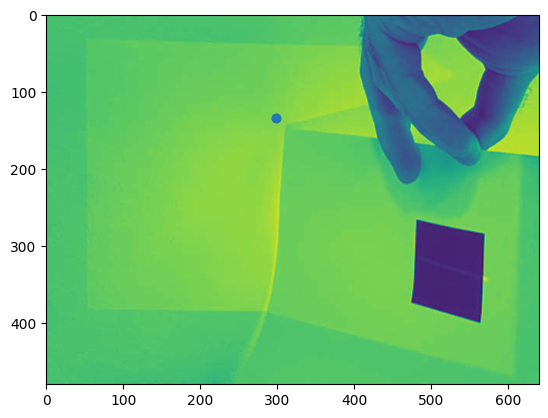

In [166]:
plt.imshow(frame)
plt.scatter(np.array(rect_mids)[:,0],np.array(rect_mids)[:,1])

In [ ]:
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

rectangles = []
for contour in contours:
    # Approximate the contour
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Check if it's a rectangle
    if len(approx) == 4 and cv2.isContourConvex(approx):
        # Calculate the aspect ratio and area
        area = cv2.contourArea(approx)
        if area > 100:  # Filter small shapes
            # check if the rectangle is black
            x, y, w, h = cv2.boundingRect(approx)
            if frame[y:y+h, x:x+w].mean() < 150:
                raise
                rectangles.append(approx)
# find center of the rectangles 
rect_mid = []
for rect in rectangles:
    rect_mid.append(rect.mean(0).astype(int)[0])


RuntimeError: No active exception to reraise

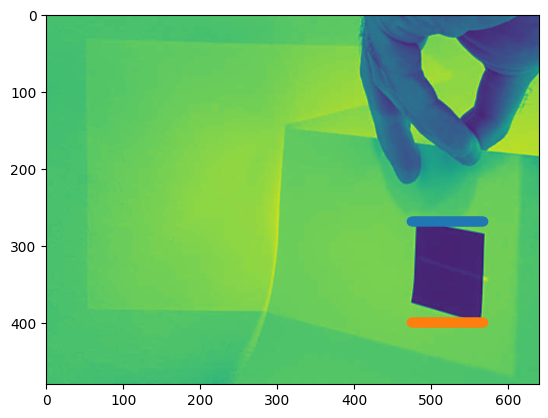

In [ ]:
plt.imshow(frame)
rectangles = find_rectangles(frame)
line_1,line_2,line_3,line_4 = find_rect_lines(rectangles[0])
plt.scatter(line_1[:,0],line_1[:,1])
plt.scatter(line_2[:,0],line_2[:,1])
# plt.scatter(line_3[:,0],line_3[:,1])
# plt.scatter(line_4[:,0],line_4[:,1])


In [92]:
approx
# connect the rectangle points


array([[[236,  75]],

       [[234, 190]],

       [[361, 193]],

       [[364,  79]]], dtype=int32)

In [86]:
x, y, w, h = cv2.boundingRect(approx)
# connect the points of the rectangle
np.arange(y,x,10)
np.arange(w,h,10)




array([], dtype=int32)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

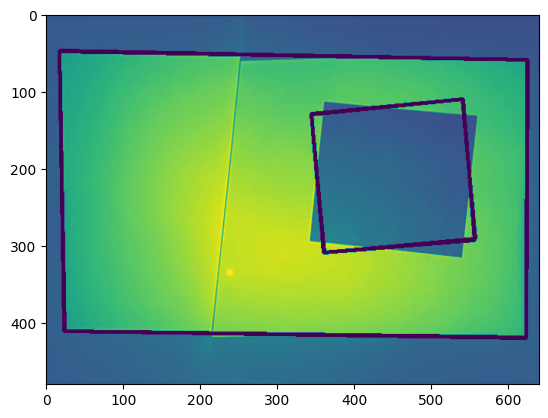

In [ ]:
output_image = frame.copy()
plt.imshow(cv2.drawContours(output_image, rectangles, -1, (0, 255, 0), 3))
plt.scatter(np.array(rect_mid)[:,0,0],np.array(rect_mid)[:,0,1])


In [150]:
# np.save('H_back.npy',H_back)
# np.save('H.npy',H)

In [ ]:
plt.imshow(pattern.transpose(1,0,2))

In [ ]:
# import numpy as np
# H_back = np.load('H_back.npy')
# H = np.load('H.npy')

## nearest neighboor

In [120]:
import numpy as np
from scipy.spatial import KDTree

# Define origin points (2D points)


# Build a KDTree for efficient nearest-neighbor search
kdtree = KDTree(new_points)

# Function to find the nearest point or interpolate
def find_nearest_or_interpolate(new_point):
    # Find the nearest origin point
    dist, idx = kdtree.query(new_point)

    if dist == 0:
        # Exact match found
        nearest_origin = new_points[idx]
        associated_target = original_points[idx]
        return associated_target
    else:
        # Interpolate between the two nearest points
        dists, indices = kdtree.query(new_point, k=2)  # Get two nearest neighbors
        p1, p2 = new_points[indices]
        t1, t2 = original_points[indices]
        
        # Compute weights for interpolation
        w1 = 1 / dists[0]
        w2 = 1 / dists[1]
        total_weight = w1 + w2
        w1 /= total_weight
        w2 /= total_weight
        
        # Interpolate target point
        interpolated_target = w1 * t1 + w2 * t2
        return interpolated_target


array([460, 916])

In [114]:
warped_points_pred

array([463, 917])

## use dnn to convert

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

    